In [ ]:
import os
import json
import math
import numpy as np

# Reading Mat File
import scipy.io

# For reading and creating tables
import pandas as pd

# To Interpolate storm center lon and lat
from scipy import interpolate

# For Creating Images
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# To find Great Circle Distance
from cartopy import geodesic
import shapely.geometry as sgeom

# For Converting Dates
import matplotlib.dates as mpldate

# To Mask and Find Land and CoastLine
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from shapely.ops import unary_union
from shapely.prepared import prep

SSMIS channels, from pg 32 of https://pps.gsfc.nasa.gov/Documents/L1C_ATBD.pdf
Swath S1 has three low-frequency channels (19V, 19H, and 22V). 
Swath S2 has two low frequency channels (37V and 37H). 
Swath S3 has four high-frequency channels (150H, 183+/- 1H, 183+/-3H, and 183+/-7H). 
S4 has two high-frequency channels (91V and 91H). 
All the above frequencies are in GHz.

GMI channels, from pg 17 https://pps.gsfc.nasa.gov/Documents/L1C_ATBD.pdf
L1CGMI contains common calibrated brightness temperatures from the GMI passive microwave instrument flown on the GPM satellite. L1CGMI has two swaths. 
Swath S1 has nine channels that are similar to TRMM TMI (10V, 10H, 19V, 19H, 23V, 37V, 37H, 89V, and 89H). 
Swath S2 has four channels similar to the Advanced Microwave Sounding Unit – B (AMSU-B) (166V, 166H, 183+/-3V, and 183+/-8V). Data for both swaths are observed in the same revolution of the instrument.

### Helper Functions

In [ ]:
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def IsLand(lon,lat):
    global land
    for x in lon:
        for y in lat:
            if land.contains(sgeom.Point(x,y)):
                return True
    return False

def GetSerialDate( normal_date ):
    return mpldate.date2num(normal_date)

def GetSerialDateFromString( str_name ):
    return mpldate.datestr2num(str_name) 

def MakeDir(path):
    if os.path.isdir(path) == False:
        os.mkdir(path)

### To Read .mat Files use MatReader Class

In [ ]:
class MatReader():   
    def __init__(self,matpath):
        # Will be useful in Child Class
        self._mErrors = {}
        self._mMatPath = "..\\"+matpath
             
    def ReadMatFile(self, matFile):
        self._mErrors[0] = ["Invalid Lat and Lon values     : ",[]]
        self._mErrors[1] = ["Invalid shape of Frequency     : ",[]]
        self._mErrors[2] = ["Invalid Brightness Temperature : ",[]]
        self._mErrors[3] = ["Land found in smaller region   : ",[]]
        
        try:
            mat = scipy.io.loadmat(self._mMatPath+matFile)
        except:
            msg = "Error Reading File: " + str( self._mMatPath+matFile ) 
            print( msg )
            return 
        
        swaths = mat["passData"][0][0]
        return swaths

### Create Images for multiple or single Frequency

In [ ]:
freq_to_swath = {}
# Index 0 means swath number [ S1, S2, S3, S4 ]
# Index 1 for PCT Frequency is the equation value and for normal frequency i.e in S1/S2/S3/S4 where it belongs (index in that swath)
# Index 2 is the colormap range
# Index 3 is the validation range for the max_tbs for min_tbs it should be >0
freq_to_swath['19']  = [0,[2.400, 1.400],[270,320],400]
freq_to_swath['19V'] = [0,0,[185,295],400]
freq_to_swath['19H'] = [0,1,[110,290],400]
freq_to_swath['22V'] = [0,2,[205,290],400]

freq_to_swath['37']  = [1,[2.150, 1.150],[250,310],400]
freq_to_swath['37V'] = [1,0,[205,290],400]
freq_to_swath['37H'] = [1,1,[135,290],400]

freq_to_swath['91']  = [3,[1.751, 0.751],[135,300],320] 
freq_to_swath['91V'] = [3,0,[130,295],320]
freq_to_swath['91H'] = [3,1,[130,295],320]

freq_to_swath['150H'] = [2,0,[105,295],320]
freq_to_swath['183_1H'] = [2,1,[125,270],320]
freq_to_swath['183_3H'] = [2,2,[105,280],320]
freq_to_swath['183_7H'] = [2,3,[105,290],320]

class FreqReader(MatReader):
    global freq_to_swath
    
    # 1st Parameter : Location of Matfile
    # 2nd Parameter : Location where to store Images    
    def __init__(self, matpath, satpath):
        super().__init__(matpath)
        
        self.__mFreq = ""
        self.__mFile = ""
        self.__mSwaths = 0
        self.__mSatellitePath = satpath
        
    def SetFreq(self,freq):
        self.__mFreq = freq
    
    def PCT_Function(self,v,h,val):
        return val[0]*v - val[1]*h
    
    # If Center Lat and Lon are not provided will consider whole area
    def ReadFile(self, matFile, centerLon=-1000, centerLat=-1000, radius=400000):
        self.__mFile = matFile
        self.__mSwath = self.ReadMatFile(matFile)
        
        if centerLon == -1000 or centerLat == -1000:
            self.__mBoundedArea = []
        else:
            # Selecting some portion of the image by CenterLon and CenterLat
            circle= geodesic.Geodesic().circle(centerLon, centerLat, radius)
            poly = sgeom.Polygon(circle)
            self.__mBoundedArea = [poly.bounds[0], poly.bounds[2], poly.bounds[1], poly.bounds[3]]
        
        self.__FreqCheck()
        
        for k,v in self._mErrors.items():
            if len(v[1]) != 0:
                print(v[0]+matFile+" : "+str(v[1]))       
    
    def __FreqCheck(self):
        # Iterate over all Frequencies
        if freq_to_swath.get(self.__mFreq) == None:
            self.__ReadAllFreq()
        else:
            self.__ReadFreq(self.__mFreq,freq_to_swath[self.__mFreq])
    
    def __ReadAllFreq(self):
        for freq,swathList in freq_to_swath.items():
            self.__ReadFreq(freq, swathList)
    
    def __ReadFreq( self, freq, swathList ):
        
        # Setting Freq Path
        freqPath = self.__mSatellitePath+"\\"+freq
        
        # Reading Freqdata
        swath_data = self.__mSwath[ swathList[0] ]
        lat = swath_data[0][0][1]
        lon = swath_data[0][0][2]
        channel = swath_data[0][0][3]

        # Calculating PCT values for specific frequencies
        if freq == '19' or freq=='37' or freq=='91':
            tbs = self.PCT_Function( channel[0], channel[1], swathList[1] )
        else:
            tbs = channel[swathList[1]]

        goForward, msg = self.__CheckCriteria(lon,lat,tbs, swathList[3])
        if goForward == False:
            self._mErrors[msg][1].append(freq)
            return 
        
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Another Check to see if the covered area is on land
        if len(self.__mBoundedArea) != 0:
            if IsLand( np.arange(self.__mBoundedArea[0],self.__mBoundedArea[1],0.1),np.arange(self.__mBoundedArea[2],self.__mBoundedArea[3],0.1)  ):
                plt.close()
                self._mErrors[3][1].append(freq)
                return
            ax.set_extent( self.__mBoundedArea )
            ax.set_xticks(list(np.arange(self.__mBoundedArea[0],self.__mBoundedArea[1],5)), crs=ccrs.PlateCarree())
            ax.set_yticks(list(np.arange(self.__mBoundedArea[2],self.__mBoundedArea[3],5)), crs=ccrs.PlateCarree())
        else:
            # Axes (Lat and Lon)
            ax.set_xticks(list(np.arange(-180,180,5)), crs=ccrs.PlateCarree())
            ax.set_yticks(list(np.arange(-90,90,5)), crs=ccrs.PlateCarree())
        
        # Creating Directory for Frequency
        MakeDir(freqPath)        
        
        # Mapping Lon, Lat and Brightness Temperature
        # vmin and vmax sets the colorbar range according to frequency
        pc = ax.pcolormesh(lon, lat, tbs, cmap="jet_r")
        previous_clim = pc.get_clim()
        pc.set_clim(swathList[2][0], swathList[2][1])
        
        # Mask Land and CostLines
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='black')
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', facecolor='black')
        
        # Removes extra padding from the figure
        plt.tight_layout(pad=0)

        # To add colorbar
        plt.colorbar(pc)

        # Storing the Image at the mentioned location
        # Setting Image Path
        minTbs = "{:.2f}".format(previous_clim[0])
        maxTbs = "{:.2f}".format(previous_clim[1])
        imgPath = freqPath+"\\"+self.__mFile[:len(self.__mFile)-4]+"_"+minTbs+"_"+maxTbs+".png"
        plt.savefig(imgPath,bbox_inches = 'tight', pad_inches = 0)
        plt.close()
        
                
    def __CheckCriteria(self, lon, lat, tbs,max_tbs):
        # If any of the Lat and Lon in the file are invalid
        if  np.any(lat>=91) or np.any(lat<=-91) or np.any(lon>= 181) or np.any(lon<=-181):
            return False, 0
        
        if tbs.shape[0] == 0 or tbs.shape[1] == 0:
            return False, 1
        
        # If any brightness temperature has value above max value
        # and below min value then its invalid
        if np.any(tbs > max_tbs) or np.any(tbs<0):
            return False, 2
        
        return True, 4

### Reads All the MatFiles present in the Storm
Analyzes the BestTrack file to provide valuable parameters useful in Clustering and creation of Images

In [ ]:
import time
class StormReader():
    def __init__(self,stormDict,region,year,stormNo,path= "..\\..\\MyCreatedData_New\\"):
        self.__mStormDict = stormDict
        self.__mYear = year
        self.__mRegion = region
        self.__mStormNo = stormNo
        
        # Setting the path where Images will be created
        MakeDir(path+self.__mRegion)
        MakeDir(path+self.__mRegion+"\\"+self.__mYear)
        MakeDir(path+self.__mRegion+"\\"+self.__mYear+"\\"+self.__mStormNo)
        self.__mInitialDir = path+self.__mRegion+"\\"+self.__mYear+"\\"+self.__mStormNo+"\\"
        self.__mSatelliteDir = 0
        
        # Unique for each storm
        self.__mRootDirOfMatFile = 0
        self.__mMatFiles = 0
        self.__mBestTrack = 0
        self.__mBestTrackDate = 0
        
        
        # Unique for each satellite
        self.__mFreqReaderClass = 0
        
        # Logger
        self.__mLog = 0
        
        # Analyzing BestTrack File
        bestTrack = self.__mStormDict["BestTrack"]
        reducedFile = ""
        for fi in bestTrack[1]:
            if "Reduced_Trackfile" in fi:
                reducedFile = fi
                break

        if reducedFile == "":
            print("Reduced_Trackfile not found :",region,year,stormNo)
            self.__mHasBestTrack = False
        else:
            filename = "..\\" + bestTrack[0] + reducedFile
            self.__mBestTrack = pd.read_csv( filename,header=None,delim_whitespace=True )
            self.__mBestTrack = self.__mBestTrack.rename(columns={ 0:"year",1:"month",2:"day",3:"hour",4:"lat",5:"lon",6:"pressure", 7:"windspeed" } )
            self.__mBestTrack["date"] = pd.to_datetime( self.__mBestTrack[["year","month","day","hour"]])
            self.__mBestTrack = self.__mBestTrack.drop(columns=["year","month","day","hour"] )
            self.__mBestTrack = self.__mBestTrack[["date","lat","lon","pressure","windspeed",8]] 
            self.__mBestTrackDate = GetSerialDate( self.__mBestTrack["date"] ) - GetSerialDate( self.__mBestTrack["date"][0] )

            self.__mLat_Interpolation_Fun = interpolate.CubicSpline(self.__mBestTrackDate, self.__mBestTrack["lat"])
            self.__mLon_Interpolation_Fun = interpolate.CubicSpline(self.__mBestTrackDate, self.__mBestTrack["lon"])
            self.__mHasBestTrack = True
        
    def DrawGraph(self):
        if self.__mHasBestTrack == False:
            print("Storm : "+ self.__mInitialDir +" has no Best Track File")
            return
        fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12, 5))
        
        ax[0].title.set_text("Time vs Latitude")
        ax[0].plot(self.__mBestTrackDate, self.__mBestTrack["lat"], 'o', label='data')
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("Center Coordinates : Latitude")
        ax[0].legend(loc='upper left', ncol=2)
        
        ax[1].title.set_text("Time vs Longitude")
        ax[1].plot(self.__mBestTrackDate, self.__mBestTrack["lon"], 'o', label='data')
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Center Coordinates : Longitude")
        ax[1].legend(loc='upper left', ncol=2)
        fig.tight_layout(pad=3.0)
        
        plt.savefig("interpolation.png")
        
        plt.show()
        
        
    def ReadStorm(self,drawFullImage = True):
        start = time.time()
        if self.__mHasBestTrack == False:
            msg = "Total time Reading: " + self.__mYear + " " + self.__mRegion + " " + self.__mStormNo + ": " + str( (time.time()-start)/60 ) + " minutes"
            print("===========================================================")
            print(msg)
            print("===========================================================")
            return
        
        self.__mStormBestTrack = pd.DataFrame( columns= ['FileName','Lon','Lat','Pressure','Windspeed'])
        
        # Iterate over all the Satellites in this storm
        for f_,files in self.__mStormDict.items():
            if f_ == "BestTrack":
                continue
            
            MakeDir(self.__mInitialDir+f_)
            self.__mSatellitePath = self.__mInitialDir+f_+"\\"
            
            # files[0] : root dir where all mat files are
            # files[1] : set of mat files for satellite f_16/17/18/19
            self.__mRootDirOfMatFile = "..\\" + files[0]
            matFiles = files[1]
            
            self.__mFreqReaderClass = FreqReader(self.__mRootDirOfMatFile,self.__mSatellitePath)
            
            # Iterate over all Matfiles
            for filename in matFiles:
                self.__ReadMatFiles(filename,drawFullImage)
            
        self.__mStormBestTrack.to_csv( self.__mInitialDir+"StormData.txt", sep='\t', index=False,encoding='utf-8')
        
        msg = "Total time Reading : " + self.__mYear + " " + self.__mRegion + " " + self.__mStormNo + ": " + str( (time.time()-start)/60 ) + " minutes"
        print("===========================================================")
        print(msg)
        print("===========================================================")
        
    def __ReadMatFiles(self,filename,drawFullImage=True):
        matfile_date = GetSerialDateFromString(filename[:15])
        
        # Finding Necessary details from the BestTrack File
        centerLon, centerLat, pressure, wind  = self.__CenterPositionAndWindPressure(matfile_date)
        
        if centerLon == 181 or centerLat == 91:
            return
        
        # Store Data of a .mat file in a dataframe
        self.__mStormBestTrack = self.__mStormBestTrack.append( {'FileName' : filename[ : len(filename) - 4]+".png",
                                                                    'Lon'      : centerLon,
                                                                    'Lat'      : centerLat,
                                                                    'Pressure' : pressure,
                                                                    'Windspeed': wind }, ignore_index=True)
        # Reading the MatFile
        if drawFullImage:
            self.__mFreqReaderClass.ReadFile( filename, centerLon, centerLat )
        else:
            self.__mFreqReaderClass.ReadFile( filename )
        
        
    def __CenterPositionAndWindPressure(self,matfile_date):
        xnew = matfile_date - GetSerialDate( self.__mBestTrack["date"][0] )
        newlat=91
        newlon=181
        
        # Not to consider value before and after the best track
        if xnew < 0 or xnew > self.__mBestTrackDate[len(self.__mBestTrackDate)-1]:
            return newlon,newlat, 0, 0
        
        if len(self.__mBestTrackDate) > 1:
            newlat = self.__mLat_Interpolation_Fun(xnew)
            newlon = self.__mLon_Interpolation_Fun(xnew)
        else:
            newlat = ylat
            newlon = ylon

        closest = math.inf
        rowNumber = -1
        for i in range(len(self.__mBestTrackDate)):
            if abs( self.__mBestTrackDate[i] - xnew ) < closest:
                closest = abs( self.__mBestTrackDate[i] - xnew )
                rowNumber = i
        
        return newlon,newlat, self.__mBestTrack["pressure"][rowNumber], self.__mBestTrack["windspeed"][rowNumber] 

In [ ]:
data = json.load( open( "..\\matfiles_and_best_track.json" ) )

### To create Images from a Single Storm
We can also analyze the Graph of Best Track file by Storm Class

In [ ]:
reg = 'ATL'
year = '13'
stormNo = '14'
stormDict = data[reg][year][stormNo]

# Path where Images will be stored
storeHere = os.getcwd()+"\\Images_Full\\"

sR = StormReader(stormDict,reg,year,stormNo,storeHere)

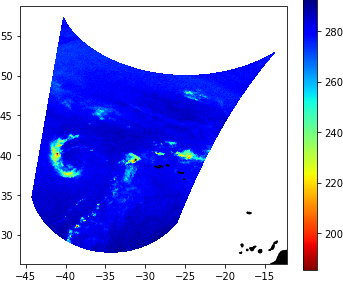

By sending False Parameter in ReadStrom() we will get images of the whole Swath.

In [ ]:
sR.ReadStorm()

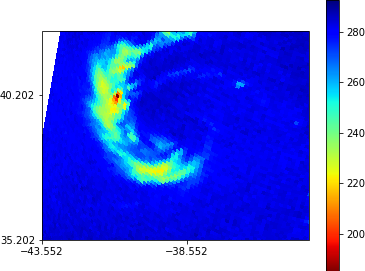

By sending No Parameter in ReadStorm() we will get images of selected area (i.e. Center Lon and Lat) <br/>
Center Lon and Lat values are calculated by interpolation done based on Best Track File and MatFile Time Stamp

In [ ]:
sR.ReadStorm()

In [ ]:
sR.DrawGraph()

### To create Images from Single Satellite
We can also create images of specific Frequency by using SetFreq( freq_parameter(string) ) function in FreqReader

In [ ]:
reg = 'ATL'
year = '13'
stormNo = '14'
satellite = 'F16'
satelliteData = data[reg][year][stormNo][satellite]

# Location and name of matFiles
matPath = satelliteData[0]
matFiles = satelliteData[1]

# Path where Images will be stored
storeHere = "Images\\"

fR = FreqReader(matPath,storeHere)
for file in matFiles:
    fR.ReadFile(file)